In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.sparse as sp
import torch

outs_dir = os.path.abspath('.')

module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import *
from utils_ecoli import *
from GSMM import *
check_device()
print(models_)

CUDA is not available.
+--------------+-----------------------+
| ORGANISM     | MODEL_SBML            |
+==============+=======================+
| ECOLI_core   | e_coli_core_SBML3.xml |
+--------------+-----------------------+
| mus_musculus | mus_iMM1415.xml       |
+--------------+-----------------------+
| homo_sapiens | Recon3D.xml           |
+--------------+-----------------------+


In [2]:
#GEM
models_dir = os.path.abspath('../../../src/sbml_models/')
organism = "ECOLI_core"
sbml_file = libsbml.readSBMLFromFile(os.path.join(models_dir, models[organism]))

gene_exp_scale = 10
bound_max = 1000
model = metabolic_model(organism, sbml_file, bound_max=bound_max)
m_model = model #copy to save

#get GSMM graph params
S = model.S
S_matrix = model.S_matrix
reactions = list(model.reactions.keys())
metabolites = list(model.metabolites.keys())

S_bool = np.array(S_matrix.astype('bool').astype('int'))
RAG = np.matmul(S_bool.T, S_bool)
adj = RAG.astype('bool').astype('int') 
adj = adj - np.identity(adj.shape[0]) #remove self loops ##symmetric boolean adj matrix
A = sp.csr_matrix(adj)
G = nx.from_scipy_sparse_array(A)

loading e_coli_core_SBML3.xml...
137 genes
72 metabolites
95 reactions with bound max 1000


In [3]:
'''
Metabolic Model Params
----------------
R_EX_o2_e________________________ O2 exchange
R_O2t___________________________ spontaneous diffusion via environmental gradient O2t
      anaerobic condition:  lower bound of the O2 exchange reaction zero flux
      (can model anaerobic as lb=0)
      R_EX_o2_e [ub,lb] = [0, 1000]

R_EX_glc__D_e____________________ glucose uptake
      lb_gluc = -18.5
      exchange reaction written as export, so limit lb not ub
R_ATPM ___________________________ ATP maintenance
      The ATP maintenance reaction (ATPM) is set with a lower bound of 0 and an upper bound of +8.39 
R_BIOMASS_Ecoli_core_w_GAM________ Biomass
      

'''

for rx in ['R_EX_o2_e', 'R_O2t']: 
      rx = m_model.reactions[rx]
      print(f'reactants: {rx.reactants} \n',
            f'products: {rx.products} \n',
            f'is exchange: {rx.is_exchange()} \n'
            )
      
for rx in ['R_EX_glc__D_e', 'R_ATPM', 'R_BIOMASS_Ecoli_core_w_GAM']:
      rx_idx = S_matrix.columns.get_loc(rx)
      r_ = m_model.reactions['R_BIOMASS_Ecoli_core_w_GAM']
      print(f'{r_.id}...........(ub,lb) {r_.lb, r_.ub}')
      print(f'index: {rx_idx}')


#check exchange
def check_exchange(m_model):
      for key, val in list(m_model.reactions.items()):
            if val.is_exchange() is True:
                  print(f'{key}......... {val.reversible} .... {list(val.reactants.keys())}, {list(val.products.keys())}')


# check_exchange(m_model)

reactants: {'M_o2_e': 1.0} 
 products: {} 
 is exchange: True 

reactants: {'M_o2_e': 1.0} 
 products: {'M_o2_c': 1.0} 
 is exchange: False 

R_BIOMASS_Ecoli_core_w_GAM...........(ub,lb) (0.0, 1000)
index: 51
R_BIOMASS_Ecoli_core_w_GAM...........(ub,lb) (0.0, 1000)
index: 15
R_BIOMASS_Ecoli_core_w_GAM...........(ub,lb) (0.0, 1000)
index: 24


genes in both:  137 
 genes in model:  137


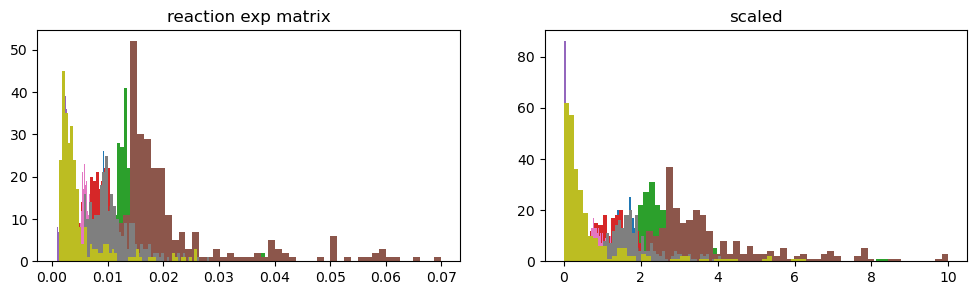

In [4]:
# original sequencing data
data_path = os.path.abspath('./../original/')
metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'), index_col = 0)
log_tpm = pd.read_csv(os.path.join(data_path, 'log_tpm.csv'), index_col = 0)

#renormalize
raw_data = 2**log_tpm
data_norm = np.sqrt(raw_data)

#format to match GSMM labels
data_norm.index = data_norm.index.str.upper()
####S0001 == B0002
data_norm.rename(index={'B0002':'S0001'}, inplace= True)

##rm 
'''
failed........(236, 'fps__fps_ptsI_ale1__1') with error 2
failed........(237, 'fps__fps_ptsI_ale1__2') with error 2
failed........(238, 'fps__fps_ptsI_ale3__1') with error 2
failed........(239, 'fps__fps_ptsI_ale3__2') with error 2
failed........(236, 'fps__fps_ptsI_ale1__1') with error 2
failed........(237, 'fps__fps_ptsI_ale1__2') with error 2
failed........(238, 'fps__fps_ptsI_ale3__1') with error 2
failed........(239, 'fps__fps_ptsI_ale3__2') with error 2
'''

data_norm.drop(data_norm.columns[236:240], axis=1, inplace = True)
metadata.drop(metadata.index[236:240], axis=0, inplace = True)

model_genes = list(model.genes.values())
print('genes in both: ', np.isin(data_norm.index, model_genes).astype('int').sum(), '\n',
      'genes in model: ', len(model_genes) 
     )

reaction_exp_matrix = map_reactions(model, data_norm)
R_, srm_ = scale_reaction_matrix(reaction_exp_matrix, gene_exp_scale, plot= True)
R, srm = merge_tx_model(model, R_, srm_)

In [5]:
from GSMM import *

/Users/hollysteach/Documents/GitHub/metabolic_GNN/src/utils.py:58: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/torch/csrc/utils/tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(indices, values, shape)


R_ATPM bounds set to.......  -10.0 1000
R_EX_glc__D_e bounds set to.......  8.39 1000


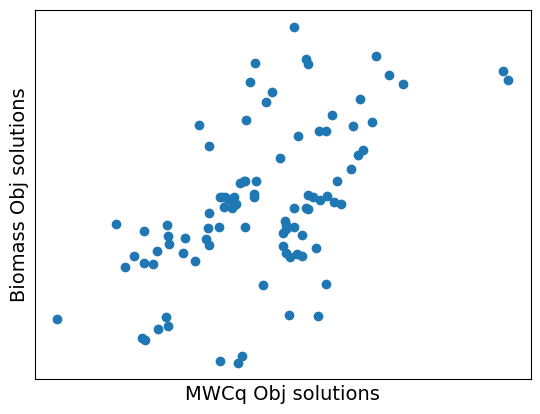

In [6]:
graph = base_graph(G, m_model)
graph.get_input_features(srm, R)
FBA = FBA_ecoli(graph)
bounds = FBA.get_constrained_bounds()
mw_nodes, mw_weights, mw_node_len = FBA.get_gt_clique()
biomass_obj, gt_clique_obj = FBA.get_gt_obj()
RES_b, RES_c, solutions_b, solutions_c, failed, f_rm = FBA.get_lp_solutions(S_matrix)

b_max = [r.fun for r in RES_b]
c_max = [r.fun for r in RES_c]

plt.scatter(x = c_max, y = b_max)
plt.xticks([])
plt.yticks([])
plt.xlabel('MWCq Obj solutions', size = 14)
plt.ylabel('Biomass Obj solutions', size = 14)
plt.show()

In [7]:
from GSMM import *
from utils_ecoli import *
def run_FBA(base_graph, srm, R, S_matrix):
    base_graph.get_input_features(srm, R)
    FBA = FBA_ecoli(base_graph, verbose = False)
    FBA.get_constrained_bounds(return_bounds= False)
    FBA.get_gt_clique(return_vals = False)
    FBA.get_gt_obj(return_objectives = False)
    FBA.get_lp_solutions(S_matrix, return_vals = False)
    return FBA


In [53]:
target_samples = 3000
noise_std = 1.5

if 'gene_exp_scale' not in globals():
    print(f'need to define gene_exp_scale...... setting to default = 10')
    gene_exp_scale = 10

n_ = 1
n_included = []
success = 0

n_samples = srm.shape[0]
aug_iter =( target_samples // n_samples)

inputs_save = []
outs_save = []


while success < aug_iter:
    n_ += 1
    np.random.seed(n_)
    gene_exp_noisy = data_norm + np.random.normal(0, noise_std, data_norm.shape)
    gene_exp_noisy = gene_exp_noisy.abs()
    reaction_exp_matrix_noisy = map_reactions(model, gene_exp_noisy)
    R_, srm_ = scale_reaction_matrix(reaction_exp_matrix_noisy, gene_exp_scale, plot= False)
    R_n, srm_n = merge_tx_model(model, R_, srm_)
    
    FBA = run_FBA(graph, srm_n, R_n, S_matrix)

    if FBA.failed > 0:
        print(f'failed for iter {n_}')
        continue
    else:
        print(f'saving vars for iter {n_}')
        n_included += [n_]
        inputs_save += [[gene_exp_noisy, R_n, srm_n]]
        outs_save += [FBA]
        success += 1
    
    

saving vars for iter 2
saving vars for iter 3
saving vars for iter 4
saving vars for iter 5
saving vars for iter 6
saving vars for iter 7
saving vars for iter 8
saving vars for iter 9
saving vars for iter 10
saving vars for iter 11


In [82]:
# save augmented dsets
data_aug = pd.concat([f[0] for f in inputs_save], axis = 1)
R_aug = pd.concat([f[1] for f in inputs_save], axis = 0)
srm_aug = pd.concat([f[2] for f in inputs_save], axis = 0)

d = pd.concat([data_norm, data_aug], axis = 1)
r = pd.concat([R, R_aug], axis = 0)
s = pd.concat([srm, srm_aug], axis = 0)


In [106]:
sample_labels = srm.index
aug_labels = sample_labels.tolist()
for i, n in enumerate(n_included):
    aug_labels += [f'{s}_{i}' for s in sample_labels]

In [111]:
r.index = aug_labels
s.index = aug_labels

In [112]:

aug_data = {'data_aug':d,
            'R_aug': r,
            'srm_aug':s}

pk_save(obj=aug_data, fname= os.path.join(outs_dir, 'aug_data_dict.pk'))

In [10]:
original_FBA = run_FBA(graph, srm, R, S_matrix)

In [11]:
combined_outs = {}

def save_combined(c_list):
    c = [item for sublist in c_list for item in sublist]
    return c

c_list = [original_FBA.bounds] + [f.bounds for f in outs_save]
c = save_combined(c_list)
combined_outs['bounds'] = c

c_list = [original_FBA.mw_nodes] + [f.mw_nodes for f in outs_save]
c = save_combined(c_list)
combined_outs['mw_nodes'] = c

c_list = [original_FBA.gt_clique_obj] + [f.gt_clique_obj for f in outs_save]
c = save_combined(c_list)
combined_outs['gt_clique_obj'] = c

c_list = [original_FBA.RES_b] + [f.RES_b for f in outs_save]
c = save_combined(c_list)
combined_outs['RES_b'] = c

c_list = [original_FBA.RES_c] + [f.RES_c for f in outs_save]
c = save_combined(c_list)
combined_outs['RES_c'] = c

pk_save(obj=combined_outs, fname= os.path.join(outs_dir, 'combined_outs.pk'))
